# Model comparison

Goal: Predict the natural log of the total transaction revenue (continuous variable) with 26 given features of customer data (include both continuous and categorical variable)

In this file, I compare the prediction performance of the following models:
- ridge regression
- lasso regression
- random forest regressor
- gradient boosting regressor

I choose the Mean Square Error (MSE) as the criterion for model evaluation. 

Results: 
The MSE of lasso and ridge regression models is higher than random forest and gradient boosting models. 
Although the testing errors of the random forest model is lower than the gradient boosting one,
with the Kaggle real test set, the performance of the gradient boosting model(root mean square error = 0.96080) is better than the random forest model (root mean square error = 1.27898)


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, SparsePCA


from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error



## Data Preprocessing

In [2]:
X = pd.read_csv('/Users/mercuryliu/Documents/Kaggle/ga-customer-revenue-prediction/X_v2.csv', \
                low_memory=False).drop(['visitHour', 'Unnamed: 0'], axis=1)
y = pd.read_csv('/Users/mercuryliu/Documents/Kaggle/ga-customer-revenue-prediction/y_v2.csv', \
                low_memory=False).drop('Unnamed: 0', axis=1)

In [3]:
y_log = np.log(y + 1)

In [4]:
len(X.columns)

26

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=42)

#remeber to reshape y to 1d array, otherwise warning message would be raised
y_train = y_train.to_numpy().reshape(len(y_train),)
y_test = y_test.to_numpy().reshape(len(y_test),)


In [6]:
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

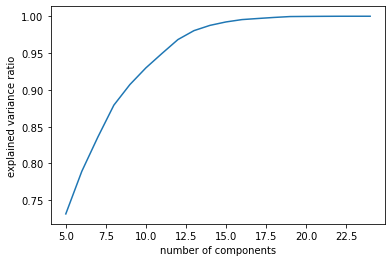

In [7]:
var = []
for i in range(5, 25, 1):
    pca = PCA(n_components = i)
    X_train_r = pca.fit_transform(X_train_s)
    k = np.sum(pca.explained_variance_ratio_)
    var.append(k)

#Since I want a dataset that can explain at least 95% of the variance
#set n_components = 12
plt.plot(list(range(5, 25, 1)), var)
plt.xlabel('number of components')
plt.ylabel('explained variance ratio')
plt.show()

In [8]:
pca_train = PCA(n_components = 12)
X_train_r = pca_train.fit_transform(X_train_s)

pca_test = PCA(n_components = 12)
X_test_r = pca_test.fit_transform(X_test_s)

In [9]:
np.sum(pca_train.explained_variance_ratio_) > 0.95

True

In [10]:
np.sum(pca_test.explained_variance_ratio_) > 0.95

True

## 1. Ridge Regression

In [11]:
param_ridge = {'alpha': [0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1, 2, 3], \
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', \
                         'sparse_cg', 'sag', 'saga']}
m1 = Ridge(random_state=2)
lr_ridge = GridSearchCV(m1, param_ridge, cv=3, scoring='neg_mean_squared_error')
lr_ridge.fit(X_train_r, y_train)


GridSearchCV(cv=3, estimator=Ridge(random_state=2),
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1, 2, 3],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga']},
             scoring='neg_mean_squared_error')

In [12]:
lr_ridge.best_params_

{'alpha': 3, 'solver': 'lsqr'}

## 2. Lasso Regression

In [13]:
param_lasso = {'alpha': [0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1, 2, 3]}
m2 = Lasso(random_state=2)
lr_lasso = GridSearchCV(m2, param_lasso, cv=3, scoring='neg_mean_squared_error')
lr_lasso.fit(X_train_r, y_train)


GridSearchCV(cv=3, estimator=Lasso(random_state=2),
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1, 2, 3]},
             scoring='neg_mean_squared_error')

In [14]:
lr_lasso.best_params_

{'alpha': 0.01}

## 3. Random Forest 

In [15]:
import time

from scitime import RuntimeEstimator
estimator = RuntimeEstimator(meta_algo='RF', verbose=3)
tree_model = RandomForestRegressor(max_depth=i,random_state=2, bootstrap=False)

# run the estimation
estimation, lower_bound, upper_bound = estimator.time(tree_model, X_train_r, y_train)


scitime.estimate.RuntimeEstimator:DEBUG:The model would fit. Moving on
scitime.estimate.RuntimeEstimator:DEBUG:Fetching estimator: RF_RandomForestRegressor_estimator.pkl
scitime.estimate.RuntimeEstimator:INFO:Training your model for these params: {'total_memory': [17179869184], 'available_memory': [1575047168], 'num_cpu': [8], 'num_rows': [83484], 'num_features': [12], 'n_estimators': [100], 'max_depth': [24], 'min_samples_split': [2], 'min_samples_leaf': [1], 'min_weight_fraction_leaf': [0.0], 'max_features': ['auto'], 'criterion': ['mse'], 'max_leaf_nodes': [None], 'min_impurity_decrease': [0.0], 'min_impurity_split': [None], 'bootstrap': [False], 'oob_score': [False], 'n_jobs': [None]}
scitime.estimate.RuntimeEstimator:INFO:Transforming dataset for semi dummy features
scitime.estimate.RuntimeEstimator:WARNING:Parameters ['max_samples', 'ccp_alpha', 'verbose', 'random_state', 'warm_start'] will not be accounted for
scitime.estimate.RuntimeEstimator:INFO:Training your RandomForestRegr

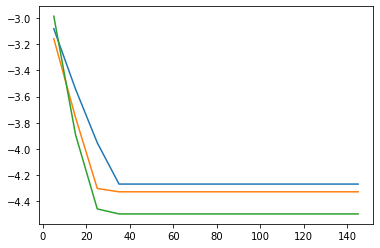

CPU times: user 34min 54s, sys: 5.5 s, total: 34min 59s
Wall time: 35min


In [18]:
%%time
sm_tree_depths = list(range(5, 150, 10))
cv_sc = []
for i in sm_tree_depths:
    tree_model = RandomForestRegressor(max_depth=i,random_state=2, bootstrap=False)
    cv_scores = cross_val_score(tree_model, X_train_r, y_train, cv=3, scoring='neg_mean_squared_error')
    cv_sc.append(cv_scores)

plt.plot(sm_tree_depths, cv_sc)
plt.show()
#max_depth = 35, afte 35, the performance do not improve 

## 5. Prediction

In [23]:
%%time

#fit models with the best parameters 
#ridge
ridge_b = Ridge(random_state=2, alpha=3, solver='lsqr')
ridge_b.fit(X_train_r, y_train)
#lasso
lasso_b = Lasso(random_state=2, alpha=0.01)
lasso_b.fit(X_train_r, y_train)

#random forest
rf_b = RandomForestRegressor(max_depth=35, max_features='sqrt', random_state=2, bootstrap=False)
rf_b.fit(X_train_r, y_train)

#gradient boosting
gb_b = GradientBoostingRegressor(n_estimators=70, max_depth=20, min_samples_leaf=20,\
                                  loss='ls', learning_rate=0.05, criterion='mse',\
                                  max_features='sqrt', random_state=2)
gb_b.fit(X_train_r, y_train)



CPU times: user 43.9 s, sys: 397 ms, total: 44.3 s
Wall time: 43.2 s


GradientBoostingRegressor(criterion='mse', learning_rate=0.05, max_depth=20,
                          max_features='sqrt', min_samples_leaf=20,
                          n_estimators=70, random_state=2)

In [24]:
models_b = [ridge_b, lasso_b, rf_b, gb_b]
mse_test = []
mse_train = []

for i in range(len(models_b)):
    #testing error
    y_pred = models_b[i].predict(X_test_r)
    test_e = mean_squared_error(y_test, y_pred)
    mse_test.append(test_e)
    
    #training error
    y_pred_train = models_b[i].predict(X_train_r)
    train_e = mean_squared_error(y_train, y_pred_train)
    mse_train.append(train_e)


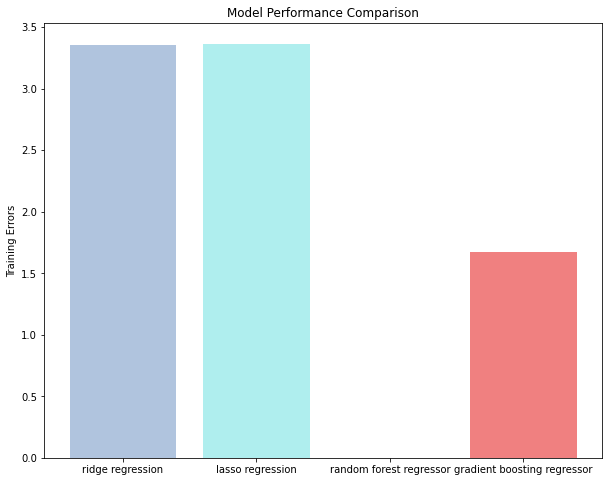

In [31]:
plt.figure(figsize=(10,8))
c = ['lightsteelblue', 'paleturquoise', 'lemonchiffon', 'lightcoral']
plt.bar(name, mse_train, color = c)
plt.ylabel('Training Errors')
plt.title('Model Performance Comparison')
plt.show()

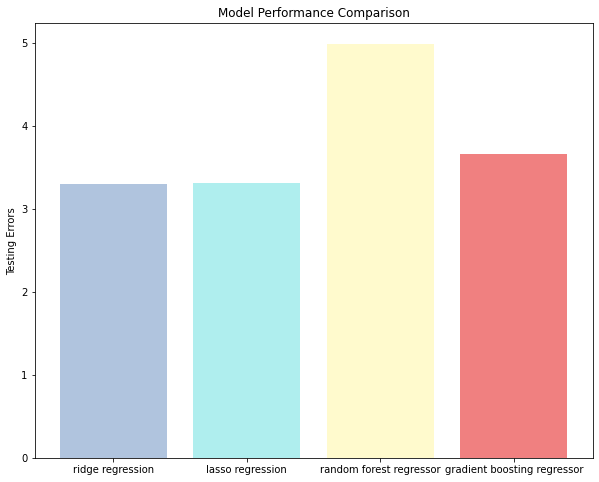

In [32]:
plt.figure(figsize=(10,8))

name = ['ridge regression', 'lasso regression', 'random forest regressor', 'gradient boosting regressor']
c = ['lightsteelblue', 'paleturquoise', 'lemonchiffon', 'lightcoral']
plt.bar(name, mse_test, color = c)
plt.ylabel('Testing Errors')
plt.title('Model Performance Comparison')
plt.show()